# Forward DID 

Based on Kathy Li's [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4213705) that presents a simple recursive way of selecting a subset of control units for difference in differences.

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, statsmodels.formula.api as smf
from itertools import islice
from scipy import stats
from statsmodels.regression.linear_model import OLS
pd.options.mode.chained_assignment = None  # get rid of annoying assignment warnings in Pandas,default='warn'

%matplotlib inline

In [22]:
class FDID():
    def __init__(self
                 , df # pandas dataframe
                 , treated # list of id's of treated units
                 , control # list of control unit id's
                 , unit = 'unit' # string, column name of unit identifier
                 , after = 'after' # string, column name for 'after identifier'
                 , dv = 'y' # string, column name of dependent variable
                 , t = 't' # string, column name of time variable
                 , ci = .95
                ):
        self.df = df.copy()
        self.treated = treated.copy()
        self.control = control.copy()
        self.unit = unit
        self.after = after
        self.dv = dv
        self.t = t
        self.CONTROLS= {}
        self.ci_alpha = stats.norm.ppf(1-(1-ci)/2)
        self.ci = ci
        self.fx = None
    def find_subjects(self):
        """
        Finds optimal subset of equally weighted controls for DID
        Input: self
        Output: dict of {treatd unit id: {'controls':[list of control unit id's], 'alpha': alpha}}
        alpha = avg difference (DID offset) between control and treated unit
        """
        CONTROLS = dict()
        
        for tr in self.treated:
            controls = self.control.copy()
            ctrls = []
            best_R2 = []
            best_controls = []
            best_alpha = []
            while len(controls)>0:
                R2 = []
                for c in controls:
                    temp = self.df[self.df[self.unit].isin(ctrls+[tr, c])&(self.df[self.after]==0)]
                    temp = temp.groupby(['treated', self.t])[self.dv].mean().unstack('treated')
                    temp.columns = ['x', 'y']
                    temp['dv'] = temp.y-temp.x
                    alpha = temp.dv.mean()
                    r2 = 1-sum((temp.y-temp.x-alpha)**2)/sum((temp.y-temp.y.mean())**2)
                    R2.append((c,r2, alpha))
                rsq = pd.DataFrame(R2, columns = [self.unit, 'r2', 'alpha']).sort_values(by = 'r2', ascending = False, ignore_index= True)
                ctrls.append(rsq.unit.iloc[0])
                best_controls.append(ctrls.copy())
                best_R2.append(rsq.r2.iloc[0])
                best_alpha.append(rsq.alpha.iloc[0])
                controls = sorted(set(controls) - set(ctrls))
            idx = np.argmax(best_R2)
            CONTROLS[tr] = {'controls':best_controls[idx], 'alpha':best_alpha[idx]}
        self.CONTROLS = CONTROLS
        return CONTROLS
    def fit(self):
        """
        Computes Forward DID estimator
        Inputs: self
        Outputs: dataframe of treatment effects, 1 row = 1 treated unit
        
        """
        CONTROLS = self.CONTROLS.copy()
        if len(CONTROLS)==0:
            CONTROLS = self.find_subjects()

        fx = []
        for tr in CONTROLS.keys():
            ctrls = CONTROLS.get(tr).get('controls')
            alpha = CONTROLS.get(tr).get('alpha')
            temp = self.df[self.df[self.unit].isin(ctrls+[tr])]
            temp = temp.groupby(['treated', self.t, self.after])[self.dv].mean().unstack('treated')
            temp.columns = ['x', 'y']
            temp['y0'] = temp.x+alpha
            temp['treat_fx'] = temp.y-temp.y0
            temp.reset_index(inplace = True)
            att = temp[temp[self.after]==1].treat_fx.mean()
            mse = (temp[temp[self.after]==0].treat_fx**2).mean()
            N = temp[self.after].sum()
            N_pre = temp[temp[self.after]==0].shape[0]
            fx.append([tr, att, N, N_pre, mse])
        
        fx = pd.DataFrame(fx, columns = ['treatment_unit', 'fx', 'obs_post', 'obs_pre', 'mse'])
        
        # for inference
        fx['se'] = np.sqrt((fx.obs_post/fx.obs_pre+1)*fx.mse/fx.obs_post)
        fx['ci_{}_lb'.format(int(self.ci*100))] = fx.fx-self.ci_alpha*fx.se
        fx['ci_{}_ub'.format(int(self.ci*100))] = fx.fx+self.ci_alpha*fx.se
        self.fx = fx.copy()
        return fx

# simulate a dataset 

Simulate a dataset that satisfies parallel trends and test the FDID algorithm

In [111]:
# np.random.seed(9999)

treated = 10
controls = 50
controls_ids = np.array(list(range(controls)))
treated_ids = np.array(list(range(treated)))+controls_ids.max()+1
units = treated+controls
offset_mean,offset_std = 4,2


T1 = 40
T2 = 60
T = T1 + T2

treatment_fx = 1.5
treatment_fx_std = .2

err_sig = .25
rw_sig = .5
# randomly allocate controls to treatments
controls_ids_it = iter(controls_ids)
controls_per_treat = np.random.multinomial(controls, [1/treated]*treated)
control_ids_map = dict(zip(treated_ids,[list(islice(controls_ids_it, elem))for elem in controls_per_treat]))
 

errs = np.random.normal(0,err_sig, size = (T,units))
offsets = np.random.normal(offset_mean,offset_std, size = units)
offsets = np.repeat(offsets.reshape(1,-1), T, axis = 0)
fx = np.repeat(np.random.normal(treatment_fx, treatment_fx_std,size = (1,treated)), T2, axis = 0)
baselines = offsets+errs

data = []

# different parallel trends for each treated unit
Y = np.zeros(shape = errs.shape)
for tr in treated_ids:
    parallel_trend = np.random.normal(0,rw_sig,size = T).cumsum()
    ctrl_ids = control_ids_map.get(tr)
    ids = [tr]+list(ctrl_ids)
    y = np.repeat(parallel_trend.reshape(-1,1), 1+len(ctrl_ids), axis = 1) 
    baselines[:,ids] = baselines[:,ids]+y
data = baselines.copy()
data[-T2:,treated_ids] = data[-T2:,treated_ids] + fx
data = pd.DataFrame(data, columns = ['unit_{}'.format(i) for i in range(units)])
data['t'] = data.index.values

# reshape
data = pd.wide_to_long(data, 'unit_', 't', 'unit').reset_index().rename(columns = {'unit_':'y'})
data['after'] = (data.t>=T1).astype(int)
data['treated'] = (data.unit.isin(treated_ids)).astype(int)

In [112]:
fdid = FDID(data # pandas dataframe
            , treated_ids # list of id's of treated units
            , controls_ids # list of control unit id's
            , unit = 'unit' # string, column name of unit identifier
            , after = 'after' # string, column name for 'after identifier'
            , dv = 'y' # string, column name of dependent variable
            , t = 't' # string, column name of time variable
            , ci = .95
           )

effects = fdid.fit()

In [113]:
effects # treatment effects

,treatment_unit,fx,obs_post,obs_pre,mse,se,ci_95_lb,ci_95_ub
0,50,1.700832,60,40,0.076419,0.056428,1.590235,1.811429
1,51,1.321706,60,40,0.073557,0.055361,1.213200,1.430212
2,52,1.108556,60,40,0.104571,0.066009,0.979182,1.237931
3,53,1.695766,60,40,0.092754,0.062167,1.573921,1.817611
4,54,1.657051,60,40,0.221386,0.096044,1.468808,1.845293
5,55,1.238863,60,40,0.065040,0.052058,1.136833,1.340894
6,56,1.817813,60,40,0.092033,0.061925,1.696443,1.939184
7,57,1.340149,60,40,0.056187,0.048385,1.245315,1.434982
8,58,1.632864,60,40,0.077076,0.056670,1.521793,1.743936
9,59,1.213532,60,40,0.088191,0.060619,1.094721,1.332342


In [114]:
ATT = (effects.fx @ effects.obs_post)/effects.obs_post.sum()
s_pooled = np.sqrt(((effects.se**2) @ (effects.obs_post-1))/(effects.obs_post.sum()-len(effects)))


print('ATT: {:.2f}, SE pooled: {:.2f}, simulation truth: {:.2f}, realized truth: {:.2f}'.format(ATT, s_pooled, treatment_fx, fx.mean()))

ATT: 1.47, SE pooled: 0.06, simulation truth: 1.50, realized truth: 1.41


Treatment ID: 58


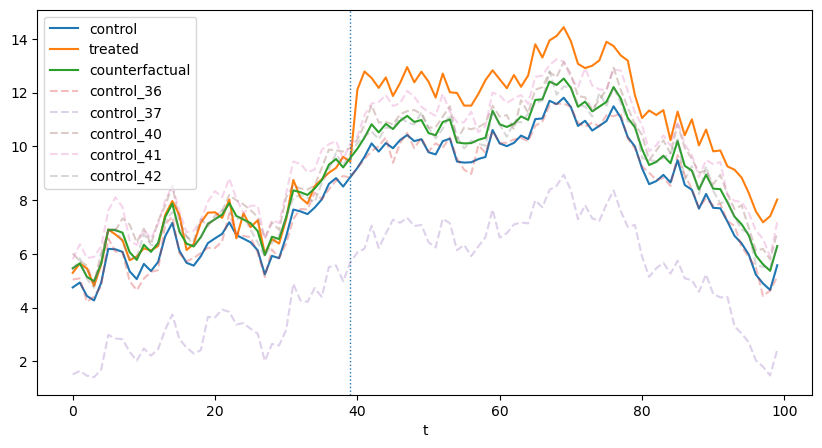

In [116]:
tr = np.random.choice(treated_ids)
print('Treatment ID: {}'.format(tr))
ctrls = fdid.CONTROLS[tr].get('controls')
alpha = fdid.CONTROLS[tr].get('alpha')
temp = data[data.unit.isin(ctrls+[tr])].groupby(['t', 'treated'])['y'].mean().unstack('treated')
temp.columns = ['control', 'treated']
temp['counterfactual']=temp.control + alpha
fig,ax = plt.subplots(1, figsize = (10,5))
temp.plot(ax=ax)
ax.axvline(x = T1-1,linestyle = ':', linewidth = 1)
temp2 = data[data.unit.isin(ctrls)].groupby(['t', 'unit'])['y'].first().unstack('unit')
temp2.columns = ['control_{}'.format(c) for c in temp2.columns]
temp2.plot(ax=ax, alpha =.3, linestyle = '--')
plt.show()